# Can Topological Divergences Help Predict the Largest Lyapunov Exponent?

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from functools import partial
from scipy import stats
from plots_and_correlates import plot_lce_estimate_and_correlation
from lca_supervised_learning import score_classification
from lca_supervised_learning import score_regression
from lca_supervised_learning import score_regression_pos
from TimeSeriesMergeTreeSimple import TimeSeriesMergeTree as TSMT
from TimeSeriesMergeTreeSimple import sum_of_edge_lengths
from ipyparallel import require
from lca_supervised_learning import score_regression_KNN
from lca_supervised_learning import score_regression_pos_KNN
from sklearn.preprocessing import MinMaxScaler
import pyplnoise
import matplotlib.pyplot as plt
from tree_offset_divergence import get_offset_divergences
from tree_offset_divergence import div_names as merge_tree_div_names
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LeaveOneOut
from scipy.stats import iqr



In [2]:
import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [3]:
def scale(ts):
    """Make range of ts fall between 0 and 1"""
    scaler = MinMaxScaler()
    return scaler.fit_transform(ts.reshape(-1, 1)).flatten()


## Get chaotic system data

In [4]:
from trajectories import generate_trajectories
SEED = 42
SAMPLES = 500
LENGTH = 500
system_data = generate_trajectories(
    RANDOM_SEED=SEED, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=SAMPLES
)

Experiment config -- SEED:42, LENGTH:500, SAMPLES:500


In [5]:
for system in system_data:
    trajectories = system_data[system]["trajectories"]
    trajectories = list(map(scale, trajectories))
    system_data[system]["trajectories"] = trajectories


## Look at offset path length distribution divergences

In [14]:
# Set up parameters for the cells below

SYSTEM = "logistic"  # current system being investigated
REP_FUNC = partial(TSMT, discrete=False)  # current mode of representing trajectories
OFFSETS = range(1,125,12)  # offsets for merge tree divergences

In [15]:
# Apply the representation constructor and get a representation of each trajectory

reps = list(map(REP_FUNC, system_data[SYSTEM]["trajectories"]))

In [16]:
# Compute divergences for the current representation

@require(partial=partial, get_offset_divergences=get_offset_divergences, OFFSETS=OFFSETS)
def merge_tree_divergences(rep):
    import numpy as np
    div_values = list(map(partial(get_offset_divergences, tsmt=rep), OFFSETS))
    return np.array(div_values).T


In [17]:

REPRESENTATION_DIVERGENCES_FUNC = merge_tree_divergences
rep_divergences = lbv.map_sync(REPRESENTATION_DIVERGENCES_FUNC, reps)
rep_divergences = np.array(rep_divergences)  # array of shape (n_trajectories, n_divergences, vector_length)

In [18]:
def score_divergences(div_names, divs, system, cv=5, n_neighbors=10):
    features = np.array(divs)
    shape = features.shape
    n_samples, n_divergences, vector_length = shape
    y = system["lces"]

    for i in range(n_divergences):
        div_name = div_names[i]
        X = features[:, i, :].reshape(n_samples, -1)
        RFC_clf = RFC(random_state=123)
        RFC_scores = cross_val_score(RFC_clf, X, y > 0, scoring="f1", cv=cv)

        KNR_clf = KNeighborsRegressor(n_neighbors=n_neighbors)

        KNR_all_scores = cross_val_score(
            KNR_clf,
            X,
            y,
            scoring="neg_mean_squared_error",
            cv=cv,
        )

        pos_mask = y > 0
        KNR_chaos_scores = cross_val_score(
            KNR_clf,
            X[pos_mask],
            y[pos_mask],
            scoring="neg_mean_squared_error",
            cv=cv,
        )

        yield {
            div_name: {
                "RFC": RFC_scores,
                "KNR_all": KNR_all_scores,
                "KNR_chaos": KNR_chaos_scores,
            },
        }


In [19]:
score_results = {SYSTEM: {}}
for result in score_divergences(merge_tree_div_names, rep_divergences, system_data[SYSTEM]):
    print(result)
    score_results[SYSTEM] |= result


{'path_length_l1': {'RFC': array([0.92957746, 0.99346405, 0.98064516, 0.96153846, 0.97468354]), 'KNR_all': array([-0.03159395, -0.01460276, -0.01803054, -0.03119553, -0.03603601]), 'KNR_chaos': array([-0.03189797, -0.00970989, -0.01074094, -0.00737038, -0.03638027])}}
{'path_length_l2': {'RFC': array([0.99337748, 0.99346405, 0.94409938, 0.96774194, 0.95364238]), 'KNR_all': array([-0.11583027, -0.01879186, -0.01633118, -0.02088784, -0.08131213]), 'KNR_chaos': array([-0.05350568, -0.00939376, -0.01037768, -0.00815617, -0.06025015])}}
{'path_length_linf': {'RFC': array([0.86060606, 0.94339623, 0.87654321, 0.91612903, 0.90140845]), 'KNR_all': array([-0.22355817, -0.02151765, -0.04503124, -0.0992852 , -0.19170402]), 'KNR_chaos': array([-0.05211884, -0.00660012, -0.0119539 , -0.02365959, -0.0620563 ])}}
{'path_length_hist_w': {'RFC': array([1.        , 1.        , 0.96815287, 0.96774194, 0.94936709]), 'KNR_all': array([-0.13695503, -0.01532889, -0.02411507, -0.02499578, -0.05670338]), 'KNR_c

In [20]:
scores_df = pd.DataFrame(score_results[SYSTEM]).applymap(np.mean).T
y = system_data[SYSTEM]["lces"]
y_iqr = iqr(y)
scores_df[["KNR_all", "KNR_chaos"]] = scores_df[["KNR_all", "KNR_chaos"]].applymap(lambda x: x/y_iqr)
scores_df

,RFC,KNR_all,KNR_chaos
path_length_l1,0.967982,-0.068070,-0.049761
path_length_l2,0.970465,-0.131084,-0.073364
path_length_linf,0.899617,-0.300895,-0.080979
path_length_hist_w,0.977052,-0.133645,-0.071153
path_length_hist_l1,0.973206,-0.119138,-0.084093
path_length_hist_l2,0.971705,-0.101820,-0.086478
path_length_hist_linf,0.970437,-0.095737,-0.084242
cophenetic_l1,0.967520,-0.103740,-0.075253
cophenetic_l2,0.955649,-0.160394,-0.074821
cophenetic_linf,0.902621,-0.249882,-0.075868


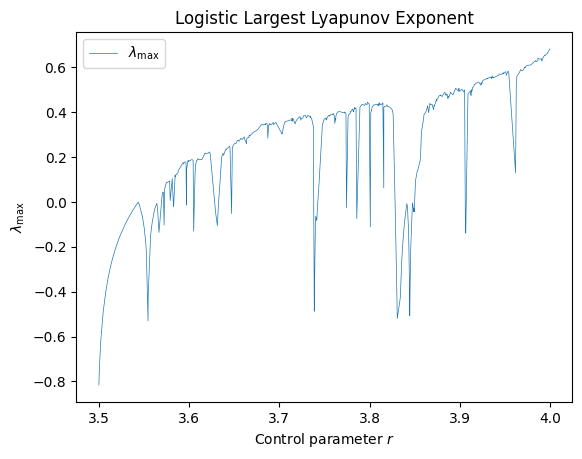

In [21]:
lces = system_data[SYSTEM]["lces"]
params = system_data[SYSTEM]["sys_params"]
param_name = system_data[SYSTEM]["param_name"]
plt.plot(params, lces, lw=0.5, label=r"$\lambda_{\max}$")
plt.title(f"{SYSTEM.capitalize()} Largest Lyapunov Exponent")
plt.xlabel(f"Control parameter ${param_name}$")
plt.ylabel(r"$\lambda_{\max}$")
plt.legend()
plt.show()